# Poisson Equation

Poisson's equation takes the form:

$$ \Delta f = g $$

The quantity of interest is $f$ and observations take the form of evaluations of the differential operator $\Delta$ applied to $f$.

In [1]:
import torch
from torch import nn
from torch import optim
import math

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
style.use("ggplot")
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np


import gaussed
from gaussed.distribution import SpectralGP
from gaussed.kernel.matern import MaternKernel

plt.rcParams['figure.figsize'] = [4,4]

## Define GP and its Laplacian

One can construct the Laplacian of the GP by either composing transformations or by directly calling ``Laplacian``.

### Composing transformations:

In [2]:
from gaussed.transforms.linear import Differentiate, Laplacian

initial_params = [torch.Tensor([0.5]).requires_grad_(True), torch.Tensor([0.2]).requires_grad_(True)]
k = MaternKernel(3, dim=2, parameters=initial_params)
qoi = SpectralGP(k)
qoi.set_domain(torch.Tensor([[-1,1],[-1,1]]))

gp_xx = Differentiate(qoi,[0],[2])()
gp_yy = Differentiate(qoi,[1],[2])()

obs = gp_xx + gp_yy

### Calling Laplacian:

In fact ``Laplacian`` is constructed by composing simpler transformations. 

In [3]:
from gaussed.transforms.linear import Linear

class Laplacian(Linear):
    def __init__(self, distribution):
        super().__init__(distribution)
        self.dim = distribution.dim

    def __call__(self):
        t_GP = Differentiate(self._distribution,[0],[2])()
        for i in range(self.dim - 1):
            t_GP += Differentiate(self._distribution,[i+1],[2])()
        return t_GP

obs = Laplacian(qoi)()

## Defining Potential

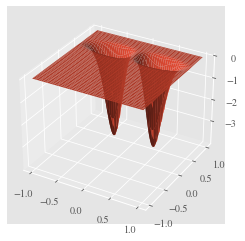

In [4]:
def exp_func(x,y):
    return  -320*torch.abs((x**3) * torch.exp(-(3.2 * x).pow(2) - (10 * (y-0.5)).pow(2)))

def target(x):
    return exp_func(x.T[0],x.T[1])
    
x = torch.linspace(-1,1,150)
y = torch.linspace(-1,1,150)
X,Y = torch.meshgrid(x,y)

Z2 = target(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Y.numpy(), X.numpy(), Z2.numpy())
plt.show()

## Experiment

In [ ]:
from gaussed.experiment import BayesRisk, EvaluationDesign, L2, Experiment

def laplace_f(x):
    X = 2 * torch.sigmoid(x) - 1
    return target(X).unsqueeze(0)

x = torch.linspace(-1,1,15)
y = torch.linspace(-1,1,15)
X,Y = torch.meshgrid(x,y)
mesh_2D = torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)

loss = L2(qoi, mesh_2D)

torch.manual_seed(4)

x = torch.linspace(-0.98,0.98,3)
XX = torch.stack(torch.meshgrid(x,x)).T.reshape(x.shape[0]**2,2)
initial_design = -torch.log((1 / (XX/2 +1/2)) - 1)

d = EvaluationDesign(obs, initial_design)
acq = BayesRisk(qoi, loss, d)
experiment = Experiment(obs, laplace_f, d, acq, m=25)

experiment.run(n=150)

## Plot output

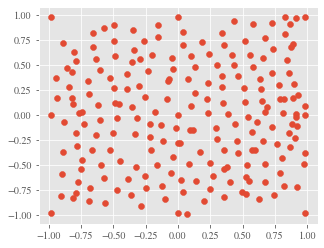

In [193]:
plt.scatter(experiment.design.design_transform(experiment.current_design).T[0],experiment.design.design_transform(experiment.current_design).T[1])

In [160]:
phi_mat = obs.basis_matrix(experiment.design.design_transform(experiment.current_design), 30)
mean, covariance_matrix = obs.condition(experiment.basis_mat, experiment.data)
mean_function = qoi.get_mean(mean)

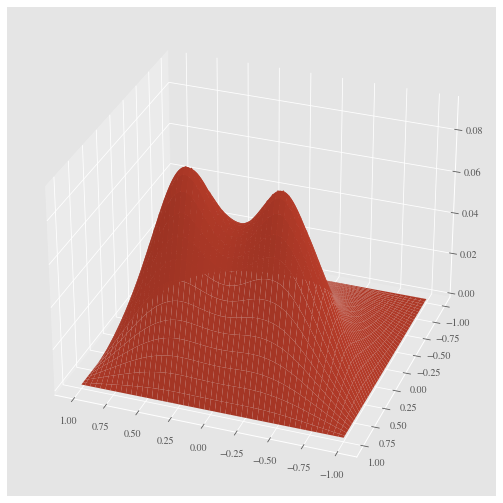

In [182]:
x = torch.linspace(-1,1,150)
y = torch.linspace(-1,1,150)
X,Y = torch.meshgrid(x,y)

Z = mean_function(torch.stack([X,Y]).T.reshape(X.shape[0]**2,2)).reshape(150,150)

fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30., azim=110)

ax.plot_surface(Y.numpy(), X.numpy(), Z.detach().numpy())
plt.show()

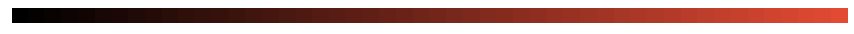

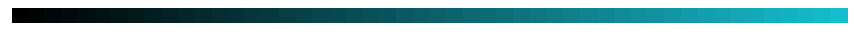

In [166]:
def make_Ramp( ramp_colors ): 

    from matplotlib.colors import LinearSegmentedColormap

    color_ramp = LinearSegmentedColormap.from_list( 'my_list', [c1  for c1 in ramp_colors ] )
    plt.figure( figsize = (15,3))
    plt.imshow( [list(np.arange(0, len( ramp_colors ) , 0.04)) ] , interpolation='nearest', origin='lower', cmap= color_ramp )
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp1 = make_Ramp( ['#000000','#E24A33'] ) 
custom_ramp2 = make_Ramp( ['#000000','#16bdcf'] ) 

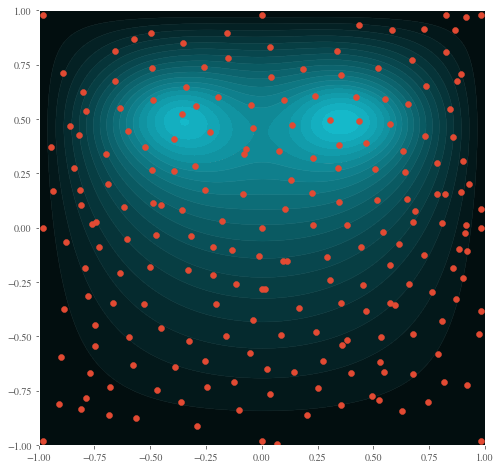

In [183]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
cs = ax.contourf(Y.numpy(), X.numpy(), Z.detach().numpy(),levels=20, cmap=custom_ramp2)
plt.scatter(experiment.design.design_transform(experiment.current_design).T[0],experiment.design.design_transform(experiment.current_design).T[1], color="#E24A33")

for c in cs.collections:
    c.set_edgecolor("face")

plt.show()

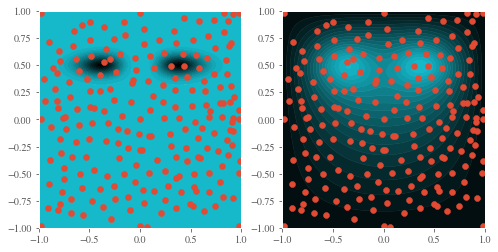

In [190]:


fig, (ax, ax2) = plt.subplots(1, 2, figsize=(8,4))
cs = ax.contourf(Y.numpy(), X.numpy(), Z2.detach().numpy(),levels=20, cmap=custom_ramp2)
ax.scatter(experiment.design.design_transform(experiment.current_design).T[0],experiment.design.design_transform(experiment.current_design).T[1], color="#E24A33")

for c in cs.collections:
    c.set_edgecolor("face")

cs = ax2.contourf(Y.numpy(), X.numpy(), Z.detach().numpy(),levels=20, cmap=custom_ramp2)
ax2.scatter(experiment.design.design_transform(experiment.current_design).T[0],experiment.design.design_transform(experiment.current_design).T[1], color="#E24A33")

for c in cs.collections:
    c.set_edgecolor("face")

plt.show()